## Intra- and Inter-brain Networks based on Structural Connectivity Matrix

This notebook is based on the anatomical connectivity kuramoto model in Dumas et. al. (2012), where each region of interest (ROI) from diffusion magnetic resonance imaging (DW-MRI) is modeled as one oscillator. We use the CoCoMac (Kötter, 2004) connectivity matrix, as distributed by the virtual brain software (Sanz Leon et al., 2013). Each hemisphere has 38 regions, giving a 76x76 structural connectivity matrix for each brain.

In [1]:
# %pip install jitcdde numpy pandas symengine matplotlib

In [2]:
# Core libraries
import pickle

# Data science libraries
import numpy as np
import pandas as pd
from symengine import sin
from jitcdde import jitcdde, t, y

# Visualization
import matplotlib.pyplot as plt

### Initialize and Shuffle Connectivity Matrices

We load and prepare the structural connectivity data for simulation. First, we load the connectivity matrix `W` (76x76) and tract lengths (76x76) from a pickle file, where `W` represents connection strengths between cortical regions. The tract lengths define physical distances between regions. We assume a 1.65 (meter per seconds) axonal velocity. 

We then implement a shuffle_connectome function that creates a randomized version of the connectivity.

In [20]:
PICKLE_PATH = "./connectivity_data.pkl" 

# Load connectome
with open(PICKLE_PATH, "rb") as f:
    W, tract, roi_names, centers_raw, hemis_raw, areas_raw = pickle.load(f)

# Centers 
roi_centers_mni = np.asarray(centers_raw, dtype=float)
roi_centers_mni /= 1000.0 # convert to m from mm
# Areas 
roi_areas_mm2 = np.asarray(areas_raw, dtype=float)

# Make symmetric and zero diagonal
W = (W + W.T) / 2.0
tract = (tract + tract.T) / 2.0
np.fill_diagonal(W, 0)
np.fill_diagonal(tract, 0)

# Convert lengths from mm to m
tract /= 1000.0  

# Cortical regions
roi_names = [name.decode("utf-8") for name in roi_names]

cortical_labels = {
    "A1": "Primary auditory",
    "A2": "Secondary auditory",
    "AMYG": "Amygdala",
    "CCA": "Anterior cingulate cortex",
    "CCP": "Posterior cingulate cortex",
    "CCR": "Retrosplenial cingulate cortex",
    "CCS": "Subgenual cingulate cortex",
    "FEF": "Frontal eye field",
    "G": "Gyrus",
    "HC": "Hippocampus",
    "IA": "Anterior insula",
    "IP": "Posterior insula",
    "M1": "Primary motor cortex",
    "PCI": "Inferior parietal cortex",
    "PCIP": "Intraparietal sulcus cortex",
    "PCM": "Medial parietal cortex",
    "PCS": "Superior parietal cortex",
    "PFCCL": "Centrolateral prefrontal cortex",
    "PFCDL": "Dorsolateral prefrontal cortex",
    "PFCDM": "Dorsomedial prefrontal cortex",
    "PFCM": "Medial prefrontal cortex",
    "PFCORB": "Orbital prefrontal cortex",
    "PFCPOL": "Prefrontal polar cortex",
    "PFCVL": "Ventrolateral prefrontal cortex",
    "PHC": "Parahippocampal cortex",
    "PMCDL": "Dorsolateral premotor cortex",
    "PMCM": "Medial (supplementary) premotor cortex",
    "PMCVL": "Ventrolateral premotor cortex",
    "S1": "Primary somatosensory cortex",
    "S2": "Secondary somatosensory cortex",
    "TCC": "Central temporal cortex",
    "TCI": "Inferior temporal cortex",
    "TCPOL": "Polar temporal cortex",
    "TCS": "Superior temporal cortex",
    "TCV": "Ventral temporal cortex",
    "V1": "Primary visual cortex",
    "V2": "Secondary visual cortex",
    "CC": "Corpus Callosum",
    "VACD": "Dorsal anterior visual cortex",
    "VACV": "Ventral anterior visual cortex",
    "Pulvinar": "Pulvinar thalamic nucleus",
    "ThalAM": "Anteromedial thalamic nucleus",
}

def side_of(code: str) -> str:
    return "Left" if code.startswith("l") else ("Right" if code.startswith("r") else "")

def base_code(code: str) -> str:
    return code[1:] if code[:1] in {"l", "r"} else code

area_df = pd.DataFrame({
        "Index": range(len(roi_names)),
        "Code": roi_names,
        "Side": [side_of(name) for name in roi_names],
        "Full Name": [cortical_labels.get(base_code(name), "") for name in roi_names],
    })

print(area_df.to_string(index=False))

hemis = np.array([0 if name.startswith("l") else 1 if name.startswith("r") else -1
                      for name in roi_names], dtype=int)

 Index    Code  Side                              Full Name
     0     rA1 Right                       Primary auditory
     1     rA2 Right                     Secondary auditory
     2   rAMYG Right                               Amygdala
     3    rCCA Right              Anterior cingulate cortex
     4    rCCP Right             Posterior cingulate cortex
     5    rCCR Right         Retrosplenial cingulate cortex
     6    rCCS Right             Subgenual cingulate cortex
     7    rFEF Right                      Frontal eye field
     8      rG Right                                  Gyrus
     9     rHC Right                            Hippocampus
    10     rIA Right                        Anterior insula
    11     rIP Right                       Posterior insula
    12     rM1 Right                   Primary motor cortex
    13    rPCI Right               Inferior parietal cortex
    14   rPCIP Right            Intraparietal sulcus cortex
    15    rPCM Right                 Med

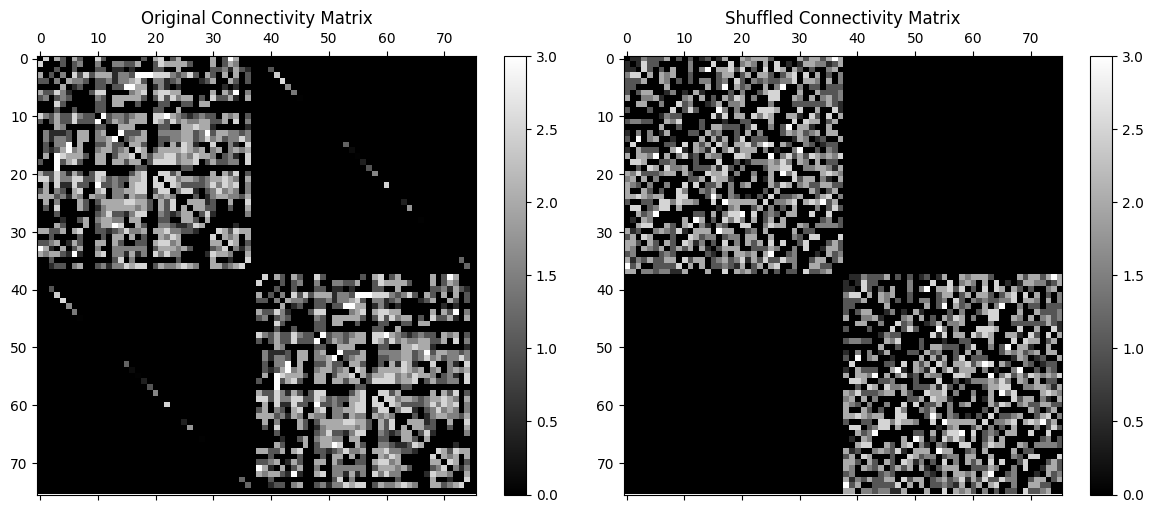

Original matrix: mean=0.494, std=0.824
Shuffled matrix: mean=0.487, std=0.821


In [4]:
def shuffle_connectome(W, D):
    """
    Shuffle the connectivity and tract length matrices while preserving:
    1. Weight/length distribution within groups
    2. Zero diagonal
    3. Symmetry
    4. Group structure (upper-left and lower-right quadrants are identical)
    
    Parameters:
        W (ndarray): Original connectivity matrix
        D (ndarray): Original tract lengths matrix
    Returns:
        tuple: (W_shuff, D_shuffled) Shuffled matrices
    """
    n = W.shape[0]
    N = n // 2  # size of each square in matrix
    W_shuff = np.zeros((n, n))
    D_shuffled = np.zeros((n, n))
    
    # Get upper triangle indices for the first quadrant (excluding diagonal)
    i_upper = np.triu_indices(N, k=1)
    
    # Get weights and lengths from upper triangle of first quadrant
    weights = W[:N, :N][i_upper]
    lengths = D[:N, :N][i_upper]
    
    # Generate random permutation
    perm = np.random.permutation(len(weights))

    # Shuffle both arrays using the same permutation
    weights = weights[perm]
    lengths = lengths[perm]
    
    # Create first quadrants
    Q1_w = np.zeros((N, N))
    Q1_d = np.zeros((N, N))
    
    # Fill upper triangles
    Q1_w[i_upper] = weights
    Q1_d[i_upper] = lengths
    
    # Make symmetric
    Q1_w = Q1_w + Q1_w.T
    Q1_d = Q1_d + Q1_d.T
    
    # Place Q1s in both upper-left and lower-right quadrants
    W_shuff[:N, :N] = Q1_w
    W_shuff[N:, N:] = Q1_w
    D_shuffled[:N, :N] = Q1_d
    D_shuffled[N:, N:] = Q1_d
    
    # Ensure diagonals remain zero
    np.fill_diagonal(W_shuff, 0)
    np.fill_diagonal(D_shuffled, 0)
    
    return W_shuff, D_shuffled

# Shuffle the original connectome
W_shuff, tract_shuff = shuffle_connectome(W, tract)

# Visualize both matrices side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot original matrix
im1 = ax1.matshow(W, cmap='gray')
ax1.set_title('Original Connectivity Matrix')
fig.colorbar(im1, ax=ax1)

# Plot shuffled matrix
im2 = ax2.matshow(W_shuff, cmap='gray')
ax2.set_title('Shuffled Connectivity Matrix')
fig.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()

# Print statistics to compare the matrices
print(f'Original matrix: mean={np.mean(W):.3f}, std={np.std(W):.3f}')
print(f'Shuffled matrix: mean={np.mean(W_shuff):.3f}, std={np.std(W_shuff):.3f}')


### Create virtual partner connectivity matrix

Also, we create a virtual partner connectome based on sensorimotor coupling between two virtual brains. This yields a 152x152 connectome to be used as a single brain network that represents all oscillators under hyperscanning settings.
The connectivitity matrix `W_vir` (152x152) with corresponding tract lengths `tract_vir` (152x152) is the dyads connected through motor and visual ROIs. Respectively, `W_vir_shuf` (152x152) with corresponding tract lengths `tract_vir_shuf` is the dyad based on shuffled connectomes.

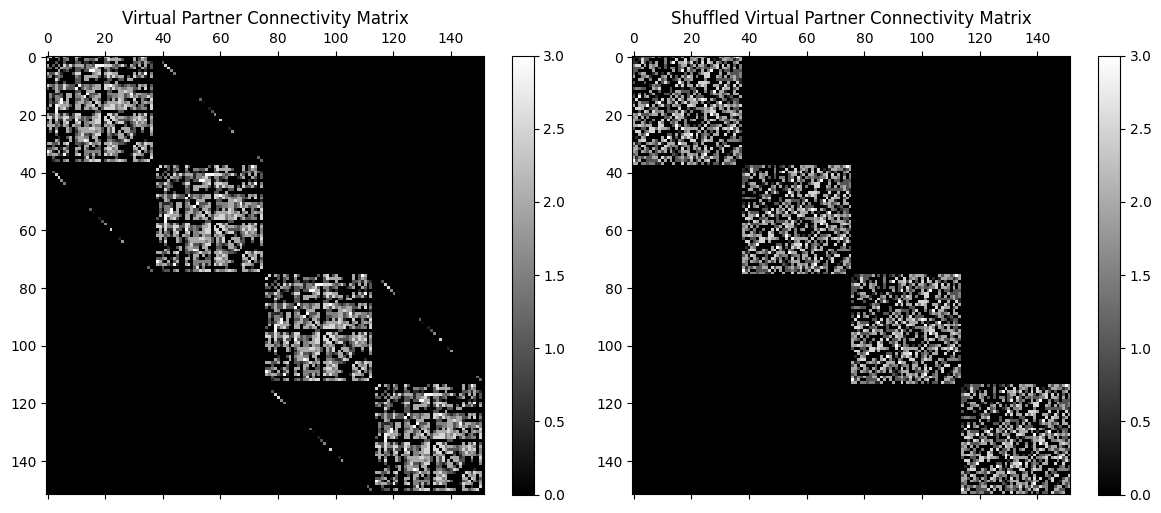

Virtual partner matrix: mean=0.247, std=0.633
Shuffled virtual partner matrix: mean=0.243, std=0.630
Matrices constructed and visualized.


In [5]:
def create_virtual_partner_connectome(W, D, C_inter=0.0):
    """
    Expands a single-brain connectome (NxN) into a dual-brain connectome (2Nx2N).

    Parameters:
        W (np.ndarray): The original NxN connectivity weight matrix. It should be
                        symmetric with a zero diagonal.
        D (np.ndarray): The original NxN tract lengths matrix, also symmetric
                        with a zero diagonal.

    Returns:
        tuple[np.ndarray, np.ndarray]: A tuple containing:
            - W_vir (np.ndarray): The expanded 2Nx2N connectivity matrix.
            - D_virtual (np.ndarray): The expanded 2Nx2N tract lengths matrix.
    """
    # Get the size of the original matrix (e.g., 76)
    n = W.shape[0]
    
    # Initialize the new, larger matrices with zeros
    W_vir = np.zeros((2 * n, 2 * n))
    D_virtual = np.zeros((2 * n, 2 * n))

    # Place original matrices on the diagonal blocks
    W_vir[:n, :n] = W
    W_vir[n:, n:] = W
    D_virtual[:n, :n] = D
    D_virtual[n:, n:] = D

    # Identify motor and visual areas' indices
    motor_labels = [
        # "rPCM", "lPCM", 
        # "rS1",  "lS1",  
        # "rPCI", "lPCI", 
        # "rPCIP","lPCIP",
        "lM1", "rM1"
    ]
    visual_labels = [
        "rV1",  "lV1", # primary visual cortex
    ]

    motor_idx  = [ roi_names.index(name) for name in motor_labels ]
    visual_idx = [ roi_names.index(name) for name in visual_labels ]

    # Weight of inter-brain connections
    mean_W = W[W > 0].mean()
    scale = (mean_W / 100.0) * C_inter

    # Create inter-brain visual-motor connections
    W_inter = np.zeros((n, n))
    D_inter = np.zeros((n, n)) # no delay in coupling as model assumption 

    W_inter[np.ix_(motor_idx, visual_idx)] = scale

    # Make the inter-brain matrices symmetric
    W_inter = W_inter + W_inter.T

    # Place inter-brain matrices on the off-diagonal blocks
    W_vir[:n, n:] = W_inter
    W_vir[n:, :n] = W_inter  
    D_virtual[:n, n:] = D_inter
    D_virtual[n:, :n] = D_inter  

    np.fill_diagonal(W_vir, 0)
    np.fill_diagonal(D_virtual, 0)

    return W_vir, D_virtual

# Create virtual partner connectomes
W_vir, tract_vir = create_virtual_partner_connectome(W, tract)
W_vir_shuff, tract_vir_shuff = create_virtual_partner_connectome(W_shuff, tract_shuff)

# Visualize both matrices side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot original matrix
im1 = ax1.matshow(W_vir, cmap='gray')
ax1.set_title('Virtual Partner Connectivity Matrix')
fig.colorbar(im1, ax=ax1)

# Plot shuffled matrix
im2 = ax2.matshow(W_vir_shuff, cmap='gray')
ax2.set_title('Shuffled Virtual Partner Connectivity Matrix')
fig.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()

# Print statistics to compare the matrices
print(f'Virtual partner matrix: mean={np.mean(W_vir):.3f}, std={np.std(W_vir):.3f}')
print(f'Shuffled virtual partner matrix: mean={np.mean(W_vir_shuff):.3f}, std={np.std(W_vir_shuff):.3f}')
print('Matrices constructed and visualized.')

### Simulate Delayed Kuramoto Oscillators

We simulate a network of coupled oscillators with transmission delays using the Kuramoto model. The dynamics of each oscillator are governed by its natural frequency and delayed coupling terms from connected oscillators. The system is integrated using `jitcdde` for delay differential equations, and synchronization is measured via the order parameter `r`.

The simulation compares synchronization patterns between the original brain connectivity and a shuffled version. 

In [46]:
# Connectome & parameters 
W_pair = [(W_vir/np.linalg.eigh(W_vir)[0].max(), tract_vir), (W_vir_shuff/np.linalg.eigh(W_vir_shuff)[0].max(), tract_vir_shuff)]
velocity = 1.65 # m/s
D = 0.1 # Dirac delta noise strength
c_intra = 2 # intra-brain coupling scale
rng = np.random.default_rng(seed=42)

# Simulation parameters
n_samp, sampling_rate = 5000, 500 
dt, t_max = 1 / sampling_rate, n_samp / sampling_rate
t_skip = 2.0 # skip initial transients

# Frequencies
n_osc = W_vir.shape[0]
N = n_osc // 2
freq = 40 + 8 * np.random.randn(n_osc)
omega = 2 * np.pi * freq

# Helpers
def make_kuramoto(W, delays, omega, c):
    def system():
        for i in range(n_osc):
            yield omega[i] + c * sum(
                sin(y(j, t - delays[i, j]) - y(i)) for j in range(n_osc) if W[j, i]
            )
    return system

def setup_solver(W, tract, c_intra=c_intra):
    delays = tract / velocity
    solver = jitcdde(make_kuramoto(W, delays, omega, c_intra), n=n_osc, verbose=False, delays=delays.flatten())
    solver.set_integration_parameters(rtol=0, atol=1e-5)
    solver.constant_past(rng.uniform(0, 2 * np.pi, n_osc), time=0.0)
    solver.integrate_blindly(np.max(delays), 0.1)
    return solver, delays

# Solver setup
solvers = [setup_solver(W, tract) for W, tract in W_pair]
times = solvers[0][0].t + np.arange(0, t_max, dt)
idx_A, idx_B = slice(0, N), slice(N, 2 * N)

# Integration function
def run_simulation(solver, delays):
    rA_vals, rB_vals, theta_list = [], [], []

    for time in times:
        phases = solver.integrate(time) % (2 * np.pi)
        phases += np.sqrt(2 * D * dt) * rng.standard_normal(n_osc)

        theta_list.append(phases)

        # compute order parameter per brain
        rA = np.abs(np.sum(np.exp(1j * phases[idx_A]))) / N 
        rB = np.abs(np.sum(np.exp(1j * phases[idx_B]))) / N
        rA_vals.append(rA)
        rB_vals.append(rB)

    r_vals = (np.asarray(rA_vals) + np.asarray(rB_vals)) / 2 # average order parameter of dyads
    theta = np.stack(theta_list, axis=1)  # shape: (n_osc, T)
    return r_vals, theta

# Run simulation
(r_values, theta), (r_values_shuf, theta_shuf) = [run_simulation(s, d) for s, d in solvers]

# Skip transients
t_skip = 2.0  # seconds
skip_idx = int(t_skip * sampling_rate)
times_stable = times[skip_idx:]
r_values, r_values_shuf = r_values[skip_idx:], r_values_shuf[skip_idx:]
theta, theta_shuf = theta[:, skip_idx:], theta_shuf[:, skip_idx:] 

# Plotting 
plt.figure(figsize=(12, 6))
plt.plot(times_stable, r_values, 'b-', linewidth=2, label='Original')
plt.plot(times_stable, r_values_shuf, 'r-', linewidth=2, label='Shuffled')
plt.xlabel('Time')
plt.ylabel('Order Parameter (r)')
plt.title('Order Parameter Evolution')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Results
print(f'Average order parameter (original): {np.mean(r_values):.3f}')
print(f'Average order parameter (shuffled): {np.mean(r_values_shuf):.3f}')

SystemExit: interrupted

/Users/junlinliow/Documents/Grad School/RA_Intern/OIST Research Internship Spring 2025/geometric hyperscanning/scripts/.kuramoto/lib/python3.13/site-packages/IPython/core/interactiveshell.py:3709: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:

# # Average across 20 simulations (subjects) 
# N_RUNS = 20

# orig_runs = []
# shuf_runs = []

# for r in range(N_RUNS):
#     rng = np.random.default_rng(seed=42 + r)

#     # fresh solvers for this replicate (reuses your existing setup function)
#     solvers_rep = [setup_solver(W, tract) for W, tract in W_pair]

#     # run both conditions 
#     r_vals_rep, r_vals_shuf_rep = [run_simulation(s, d) for s, d in solvers_rep]

#     # skip transients and collect
#     skip_idx = int(t_skip * sampling_rate)
#     orig_runs.append(r_vals_rep[skip_idx:])
#     shuf_runs.append(r_vals_shuf_rep[skip_idx:])

# orig_runs = np.vstack(orig_runs)         # shape: (N_RUNS, T_stable)
# shuf_runs = np.vstack(shuf_runs)

# # ensemble mean time series
# r_values_mean      = orig_runs.mean(axis=0)
# r_values_shuf_mean = shuf_runs.mean(axis=0)

# # stable time grid
# times_stable = times[skip_idx:]

# COL_REAL = '#009E73'   # bluish green (teal)
# COL_SHUF = '#CC79A7'   # reddish purple

# # 95% CI (unchanged)
# sem_orig  = orig_runs.std(axis=0, ddof=1) / np.sqrt(N_RUNS)
# sem_shuf  = shuf_runs.std(axis=0, ddof=1) / np.sqrt(N_RUNS)
# ci95_orig = 1.96 * sem_orig
# ci95_shuf = 1.96 * sem_shuf

# # Plotting
# plt.figure(figsize=(12, 6))
# plt.fill_between(times_stable, r_values_mean - ci95_orig, r_values_mean + ci95_orig,
#                  color=COL_REAL, alpha=0.25, linewidth=0)
# plt.fill_between(times_stable, r_values_shuf_mean - ci95_shuf, r_values_shuf_mean + ci95_shuf,
#                  color=COL_SHUF, alpha=0.25, linewidth=0)

# plt.plot(times_stable, r_values_mean,      color=COL_REAL, linewidth=2, label='Real anatomy')
# plt.plot(times_stable, r_values_shuf_mean, color=COL_SHUF, linewidth=2, label='Shuffled')
# plt.xlabel('Time (s)')
# plt.ylabel('Order Parameter (r)')
# plt.ylim(0, 1)
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # Results (time-averaged over the ensemble mean)
# print(f'Average order parameter (original, mean over {N_RUNS} runs): {r_values_mean}')
# print(f'Average order parameter (shuffled, mean over {N_RUNS} runs): {r_values_shuf_mean}')

### Simulating resting state EEG signals
We simulate resting state EEG signals to compute the Mahanalobis distance from actual EEG signals, ensuring bio-realisitc calibration of control parameters.

#### Gain matrix
A gain matrix G (shape: no. of electrodes x time points) that weighs the contribution of each source in cortical source S (shape: time points x no. of source) to a particular electrode. 

In [8]:
import os, mne

# Head model (using standard montage)
montage = mne.channels.make_standard_montage('biosemi64')
info = mne.create_info(ch_names=montage.ch_names, sfreq=500., ch_types='eeg')
info.set_montage(montage)

# Source model
subjects_dir = "/Users/junlinliow/mne_data/MNE-fsaverage-data"
subject = "fsaverage"

# fsaverage & BEM
bem_path = os.path.join(subjects_dir, subject, "bem", "fsaverage-5120-5120-5120-bem-sol.fif")
bem_sol = mne.read_bem_solution(bem_path)
src = mne.setup_source_space(subject=subject, spacing="oct6",
                             add_dist=False, subjects_dir=subjects_dir, verbose=False)

# Forward model
fwd = mne.make_forward_solution(info=info, trans='fsaverage', src=src, bem=bem_sol,
                                eeg=True, meg=False, mindist=5.0, verbose=False)
fwd = mne.convert_forward_solution(fwd, surf_ori=True, force_fixed=True, use_cps=True) # fixed orientation for 1-to-1 oscillator to dipole mapping
G = fwd['sol']['data']
print(G.shape)

Loading surfaces...

Loading the solution matrix...

Three-layer model surfaces loaded.
Loaded linear collocation BEM solution from /Users/junlinliow/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-5120-5120-5120-bem-sol.fif
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Changing to fixed-orientation forward solution with surface-based source orientations...
    [done]
(64, 8196)


#### Cortical source signals from Kuramoto phases
Cortical source signals S (shape: no. of source x timepoints) that gives a source strength at each source location by the phase of the kuramoto models oscillation as  a function of the cosine of specific kuramoto oscillator at one timepoint. 

In [58]:
from scipy.spatial import distance

def construct_source_signals(theta):
    # get source coordinates
    lh_coords = src[0]['rr'][src[0]['inuse'].astype(bool)]
    rh_coords = src[1]['rr'][src[1]['inuse'].astype(bool)]
    dipole_coords = np.vstack((lh_coords, rh_coords))

    # Compute the distance from every dipole to every CoCoMac region
    dist_matrix = distance.cdist(dipole_coords, roi_centers_mni, 'euclidean')
    dipole_to_region_map = np.argmin(dist_matrix, axis=1) # For each dipole, find the index of the closest CoCoMac region

    # compute source k based on cosine of kuramoto phase
    n_dipoles = G.shape[1]
    n_timepoints = theta.shape[1]
    S = np.zeros((n_dipoles, n_timepoints))

    # compute source k based on cosine of phase i at timepoint t
    for k in range(n_dipoles):
        region_idx = dipole_to_region_map[k]
        S[k, :] = np.cos(theta[region_idx, :])

    # EEG = G * S
    eeg_simulated = np.dot(G, S)

    return eeg_simulated

#### Compute Phase Locking Value (PLV) 

In [28]:
from scipy.signal import hilbert

def compute_plv(dyad, sfreq, mode='intra'):
    """
    Phase locking value based on sliding window with 800ms and 400ms overlap
    args: 
        1. dyadic eeg signal (shape: 2  x no. of electrodes x timepoints) 
        2. mode (str): compute plv for intra- or inter-brain electrode pairs 
    returns plv matrix (shape: no. of electrodes x no. of electrodes)
    """
    plv = []
    subj1 = dyad[0]
    subj2 = dyad[1]

    # band-pass (32-48Hz)
    eeg1 = mne.filter.filter_data(subj1, sfreq=sfreq, l_freq=32, h_freq=48, verbose=False)
    eeg2 = mne.filter.filter_data(subj2, sfreq=sfreq , l_freq=32, h_freq=48, verbose=False)

    # phase extraction via hilbert transform
    phase1 = np.angle(hilbert(eeg1, axis=-1))
    phase2 = np.angle(hilbert(eeg2, axis=-1))

    # sliding window parameters
    win_size = int(.8*sfreq)
    step_size = int(.4*sfreq)
    n_channels = phase1.shape[0]
    n_samples = phase1.shape[1]

    starts = np.arange(0, n_samples - win_size + 1, step_size)
    plv_list = []

    for start in starts:
        end = start + win_size
        p1_win = phase1[:, start:end]
        p2_win = phase2[:, start:end]

        # phase locking value
        if mode == 'intra':
            diffs = p1_win[:, None, :] - p1_win[None, :, :] # broadcast dimensions to (N,1,T) and (1,N,T), yields (N,N,T)
        else:
            diffs = p1_win[:, None, :] - p2_win[None, :, :] # inter-brain plv
        
        plv = np.abs(np.exp(1j*diffs).mean(axis=-1))
        plv_list.append(plv)

    final_plv = np.mean(plv_list, axis=0)

    return final_plv

(64, 64)


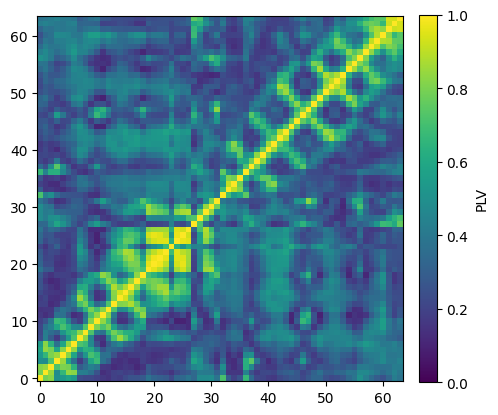

Reading /Users/junlinliow/Downloads/rest_1227_S1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        0 CTF compensation matrices available
Not setting metadata
39 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/junlinliow/Downloads/rest_1227_S2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        0 CTF compensation matrices available
Not setting metadata
39 matching events found
No baseline correction applied
0 projection items activated
(64, 64)


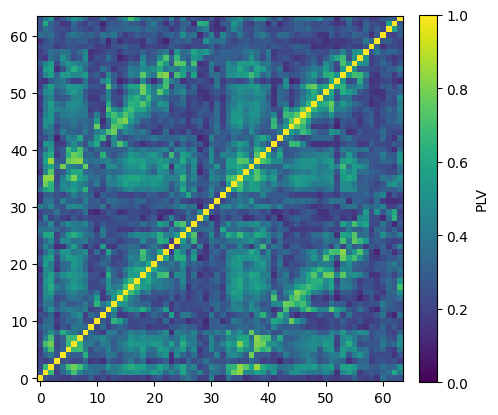

In [44]:
# simulated subjects resting state
dyad = np.stack([eeg_simulated, eeg_simulated], axis=0)
plv_sim = compute_plv(dyad, 500, mode='intra')
print(plv_sim.shape)

# Visualize PLV matrix
plt.figure(figsize=(5,4.5))
im = plt.imshow(plv_sim, vmin=0, vmax=1, cmap='viridis', origin='lower')
plt.colorbar(im, fraction=0.046, pad=0.04, label='PLV')
plt.tight_layout()
plt.show()

# for real subjects resting state 
subj1 = mne.read_epochs("/Users/junlinliow/Downloads/rest_1227_S1-epo.fif", preload=True)
subj2 = mne.read_epochs("/Users/junlinliow/Downloads/rest_1227_S2-epo.fif", preload=True)

sampling_rate = subj1.info['sfreq']

i = 0  # index of the epoch 
epoch1 = subj1.get_data()[i]   # shape: (n_channels, n_times)
epoch2 = subj2.get_data()[i]

dyad = np.stack([epoch2, epoch1], axis=0)
plv_real = compute_plv(dyad, sampling_rate, mode='intra')
print(plv_real.shape)
# Visualize PLV matrix
plt.figure(figsize=(5,4.5))
im = plt.imshow(plv_real, vmin=0, vmax=1, cmap='viridis', origin='lower')
plt.colorbar(im, fraction=0.046, pad=0.04, label='PLV')
plt.tight_layout()
plt.show()

#### Compute Mahalanobis distance
To compute the dissimilarity distances between simulated and actual resting state EEG data, we generate M_simulated (shape: no. of subjects x pairs of electrodes comparisons?) and M_real (shape: no. of subjects x ) 

In [73]:
from scipy.spatial.distance import mahalanobis

def pooled_covariance(M1, M2):
    """
    pooled covariance matrix for two groups.
    args. 
        M1 & M2 (shape: n_samples, n_features)
    """
    if M1.shape[0] <= 1:
        raise ValueError('must have more than one subject for pooled covariance')

    M1 = np.asarray(M1)
    M2 = np.asarray(M2)

    n1 = M1.shape[0]
    n2 = M2.shape[0]

    cov1 = np.cov(M1, rowvar=False, bias=False)
    cov2 = np.cov(M2, rowvar=False, bias=False)

    Sp = ((n1 - 1) * cov1 + (n2 - 1) * cov2) / (n1 + n2 - 2)
    return Sp

def compute_mahalanobis(plv_sim, plv_real):
    """
    args.
        plv matrices of simulated and real eeg (shape: no. of subj. x all combinations of electrode pairs)
    output. mahalanobis distance
    """
    covar = pooled_covariance(plv_sim, plv_real)
    print(covar.shape)
    avg_plv_sim =  plv_sim.mean(axis=0)
    avg_plv_real = plv_real.mean(axis=0)

    print(f'shape of avg_plv_sim: {avg_plv_sim.shape}')
    print(f'shape of avg_plv_real: {avg_plv_real.shape}')
    print(f'shape of covar: {covar.shape}')

    det = np.linalg.det(covar)

    is_singular = np.isclose(det, 0.0, atol=1e-10)
    print("Determinant:", det)
    print("Singular:", is_singular)

    return mahalanobis(avg_plv_sim, avg_plv_real, np.linalg.pinv(covar))

### Simulations across participants for c intra calibration

In [56]:
# Connectome & parameters 
W_pair = [(W_vir/np.linalg.eigh(W_vir)[0].max(), tract_vir), (W_vir_shuff/np.linalg.eigh(W_vir_shuff)[0].max(), tract_vir_shuff)]
velocity = 1.65 # m/s
D = 0.1 # Dirac delta noise strength
# c_intra = 2 # intra-brain coupling scale
rng = np.random.default_rng(seed=42)

# Simulation parameters
n_samp, sampling_rate = 3000, 1000 
dt, t_max = 1 / sampling_rate, n_samp / sampling_rate
t_skip = .2*n_samp/sampling_rate # skip initial 20% transients

# Frequencies
n_osc = W_vir.shape[0]
N = n_osc // 2
freq = 40 + 8 * np.random.randn(n_osc)
omega = 2 * np.pi * freq

# Helpers
def make_kuramoto(W, delays, omega, c):
    def system():
        for i in range(n_osc):
            yield omega[i] + c * sum(
                sin(y(j, t - delays[i, j]) - y(i)) for j in range(n_osc) if W[j, i]
            )
    return system

def setup_solver(W, tract, c_intra=c_intra):
    delays = tract / velocity
    solver = jitcdde(make_kuramoto(W, delays, omega, c_intra), n=n_osc, verbose=False, delays=delays.flatten())
    solver.set_integration_parameters(rtol=0, atol=1e-5)
    solver.constant_past(rng.uniform(0, 2 * np.pi, n_osc), time=0.0)
    solver.integrate_blindly(np.max(delays), 0.1)
    return solver, delays

# Solver setup
# solvers = [setup_solver(W, tract) for W, tract in W_pair]
times = solvers[0][0].t + np.arange(0, t_max, dt)
idx_A, idx_B = slice(0, N), slice(N, 2 * N)

# Integration function
def run_simulation(solver, delays):
    rA_vals, rB_vals, theta_list = [], [], []

    for time in times:
        phases = solver.integrate(time) % (2 * np.pi)
        phases += np.sqrt(2 * D * dt) * rng.standard_normal(n_osc)

        theta_list.append(phases)

        # compute order parameter per brain
        rA = np.abs(np.sum(np.exp(1j * phases[idx_A]))) / N 
        rB = np.abs(np.sum(np.exp(1j * phases[idx_B]))) / N
        rA_vals.append(rA)
        rB_vals.append(rB)

    r_vals = (np.asarray(rA_vals) + np.asarray(rB_vals)) / 2 # average order parameter of dyads
    theta = np.stack(theta_list, axis=1)  # shape: (n_osc, T)
    return r_vals, theta

n_runs = 2 # POC test
c_intra_vals = np.arange(0, 60, 0.6)
skip_idx = int(.2*n_samp) # skip initial 20% transients
timepoints_stable = int(n_samp-skip_idx)

ret = np.zeros((n_runs, len(c_intra_vals), n_osc, timepoints_stable))
ret_shuf = np.zeros((n_runs, len(c_intra_vals), n_osc, timepoints_stable))
output_dir = "sim_checkpoints"
os.makedirs(output_dir, exist_ok=True)

for i in range(n_runs):
    for j, c_intra in enumerate(c_intra_vals):
        file_path = os.path.join(output_dir, f"run_{i}_step_{j}_c_{c_intra:.1f}.npz")
        
        # Optional: Skip if the file already exists (Resume capability)
        if os.path.exists(file_path):
            print(f"Skipping: {file_path} already exists.")
            continue
        print(f'simulating for run {i+1} and intra coupling strength {c_intra}')
        # pass in c_intra
        solvers = [setup_solver(W, tract, c_intra=c_intra) for W, tract in W_pair]
        (r_values, theta), (r_values_shuf, theta_shuf) = [run_simulation(s, d) for s, d in solvers]

        # Save theta's at current run with specific c_intra
        ret[i, j, :, :] = theta[:, skip_idx:]
        ret_shuf[i, j, :, :] = theta_shuf[:, skip_idx:]

        np.savez_compressed(
            file_path, 
            theta=theta[:, skip_idx:], 
            theta_shuf=theta_shuf[:, skip_idx:],
            c_intra=c_intra,
            run_idx=i
        )



simulating for run 1 and intra coupling strength 0.0


/Users/junlinliow/Documents/Grad School/RA_Intern/OIST Research Internship Spring 2025/geometric hyperscanning/scripts/.kuramoto/lib/python3.13/site-packages/jitcxde_common/_jitcxde.py:248: UserWarning: Differential equation does not include a delay term.
  self.compile_C()
/var/folders/7s/_cwfk8cs047blktxbtmc6rj40000gn/T/ipykernel_68580/4164181440.py:46: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry (though you should think about increasing your sampling time).
  phases = solver.integrate(time) % (2 * np.pi)


simulating for run 1 and intra coupling strength 0.6
simulating for run 1 and intra coupling strength 1.2
simulating for run 1 and intra coupling strength 1.7999999999999998
simulating for run 1 and intra coupling strength 2.4
simulating for run 1 and intra coupling strength 3.0
simulating for run 1 and intra coupling strength 3.5999999999999996
simulating for run 1 and intra coupling strength 4.2
simulating for run 1 and intra coupling strength 4.8
simulating for run 1 and intra coupling strength 5.3999999999999995
simulating for run 1 and intra coupling strength 6.0
simulating for run 1 and intra coupling strength 6.6
simulating for run 1 and intra coupling strength 7.199999999999999
simulating for run 1 and intra coupling strength 7.8
simulating for run 1 and intra coupling strength 8.4
simulating for run 1 and intra coupling strength 9.0
simulating for run 1 and intra coupling strength 9.6
simulating for run 1 and intra coupling strength 10.2
simulating for run 1 and intra coupling

In [62]:
pattern = os.path.join(output_dir, "run_{run}_step_{step}_c_{c:.1f}.npz")
plv_ori = np.full((len(c_intra_vals), n_runs, G.shape[0]**2), np.nan, dtype=np.float64)
plv_shuf = np.full((len(c_intra_vals), n_runs, G.shape[0]**2), np.nan, dtype=np.float64)

# for each run (subj)
for i in range(n_runs):
    for j, c_intra in enumerate(c_intra_vals):
        file_path = pattern.format(run=i, step=j, c=c_intra)
        print(f'reading file of run {i+1} with c intra {c_intra}')

        # load file
        npz = np.load(file_path)
        theta = npz['theta']         
        theta_shuf = npz['theta_shuf']

        # forward model
        eeg_ori = construct_source_signals(theta)
        eeg_shuf = construct_source_signals(theta_shuf)

        # compute plv
        plv_o = compute_plv(np.stack([eeg_ori, eeg_ori], axis=0), sampling_rate, mode='intra')
        plv_s = compute_plv(np.stack([eeg_shuf, eeg_shuf], axis=0), sampling_rate, mode='intra')

        # yield plv matrix shape: c_intra x run x plv columns ()
        plv_ori[j, i, :] = plv_o.flatten()
        plv_shuf[j, i, :] = plv_s.flatten()

        print(f'current shape of plv ori is {plv_ori.shape}')

print(plv_ori.shape)

reading file of run 1 with c intra 0.0
current shape of plv ori is (100, 2, 4096)
reading file of run 1 with c intra 0.6
current shape of plv ori is (100, 2, 4096)
reading file of run 1 with c intra 1.2
current shape of plv ori is (100, 2, 4096)
reading file of run 1 with c intra 1.7999999999999998
current shape of plv ori is (100, 2, 4096)
reading file of run 1 with c intra 2.4
current shape of plv ori is (100, 2, 4096)
reading file of run 1 with c intra 3.0
current shape of plv ori is (100, 2, 4096)
reading file of run 1 with c intra 3.5999999999999996
current shape of plv ori is (100, 2, 4096)
reading file of run 1 with c intra 4.2
current shape of plv ori is (100, 2, 4096)
reading file of run 1 with c intra 4.8
current shape of plv ori is (100, 2, 4096)
reading file of run 1 with c intra 5.3999999999999995
current shape of plv ori is (100, 2, 4096)
reading file of run 1 with c intra 6.0
current shape of plv ori is (100, 2, 4096)
reading file of run 1 with c intra 6.6
current shape 

In [71]:
# compute plv for actual eeg 
plv_actual = np.full((n_runs, G.shape[0]**2), np.nan, dtype=np.float64)

for i in range(n_runs):
    epochs = mne.read_epochs(f"/Users/junlinliow/Downloads/rest_122{6+i}_S1-epo.fif", preload=True)
    sampling_rate = epochs.info['sfreq']
    first_epoch = epochs.get_data()[i]

    dyad = np.stack([epoch2, epoch1], axis=0)
    plv_a = compute_plv(dyad, sampling_rate, mode='intra')

    plv_actual[i, :] = plv_a.flatten()

print(plv_actual.shape)

Reading /Users/junlinliow/Downloads/rest_1226_S1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        0 CTF compensation matrices available
Not setting metadata
39 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/junlinliow/Downloads/rest_1227_S1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        0 CTF compensation matrices available
Not setting metadata
39 matching events found
No baseline correction applied
0 projection items activated
(2, 4096)


(4096, 4096)
shape of avg_plv_sim: (4096,)
shape of avg_plv_real: (4096,)
shape of covar: (4096, 4096)
Determinant: 0.0
Singular: True


/Users/junlinliow/Documents/Grad School/RA_Intern/OIST Research Internship Spring 2025/geometric hyperscanning/scripts/.kuramoto/lib/python3.13/site-packages/scipy/spatial/distance.py:1136: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


(4096, 4096)
shape of avg_plv_sim: (4096,)
shape of avg_plv_real: (4096,)
shape of covar: (4096, 4096)
Determinant: 0.0
Singular: True
(4096, 4096)
shape of avg_plv_sim: (4096,)
shape of avg_plv_real: (4096,)
shape of covar: (4096, 4096)
Determinant: 0.0
Singular: True
(4096, 4096)
shape of avg_plv_sim: (4096,)
shape of avg_plv_real: (4096,)
shape of covar: (4096, 4096)
Determinant: 0.0
Singular: True
(4096, 4096)
shape of avg_plv_sim: (4096,)
shape of avg_plv_real: (4096,)
shape of covar: (4096, 4096)
Determinant: 0.0
Singular: True
(4096, 4096)
shape of avg_plv_sim: (4096,)
shape of avg_plv_real: (4096,)
shape of covar: (4096, 4096)
Determinant: 0.0
Singular: True
(4096, 4096)
shape of avg_plv_sim: (4096,)
shape of avg_plv_real: (4096,)
shape of covar: (4096, 4096)
Determinant: 0.0
Singular: True
(4096, 4096)
shape of avg_plv_sim: (4096,)
shape of avg_plv_real: (4096,)
shape of covar: (4096, 4096)
Determinant: 0.0
Singular: True
(4096, 4096)
shape of avg_plv_sim: (4096,)
shape of avg

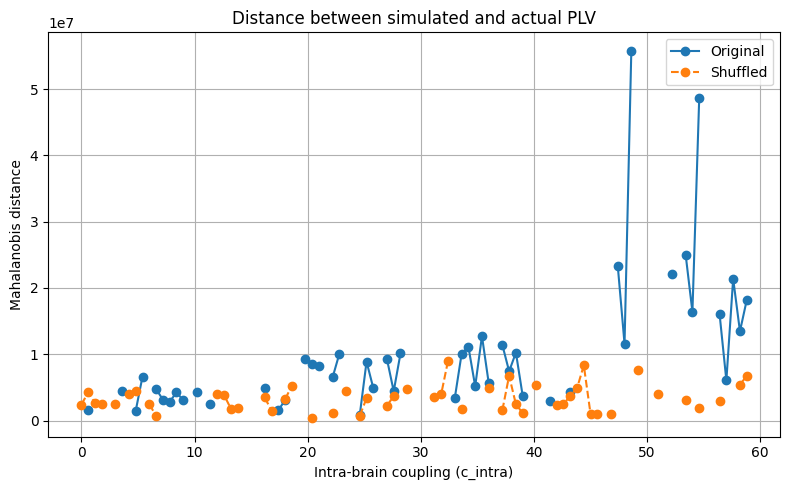

In [74]:
# compute mahalanobis distance over all c_intra for simulated and actual eeg
dist_ori = np.zeros(len(c_intra_vals))
dist_shuf = np.zeros(len(c_intra_vals))

for j, c_intra in enumerate(c_intra_vals):
    dist_ori[j] = compute_mahalanobis(plv_ori[j], plv_actual)
    dist_shuf[j] = compute_mahalanobis(plv_shuf[j], plv_actual)

plt.figure(figsize=(8, 5))
plt.plot(c_intra_vals, dist_ori, 'o-', label='Original')
plt.plot(c_intra_vals, dist_shuf, 'o--', label='Shuffled')

plt.xlabel('Intra-brain coupling (c_intra)')
plt.ylabel('Mahalanobis distance')
plt.title('Distance between simulated and actual PLV')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

